## 1. Setup
Import modules


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from collections import Counter
from __future__ import print_function
import os
import tensorflow as tf
from tensorflow import keras
# fix random seed for reproducibility
np.random.seed(1)
tf.random.set_seed(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
random_seed = 1
import warnings
warnings.filterwarnings('ignore')

## 2. Load data
Load data (it's already cleaned and preprocessed)


In [2]:
X_train = pd.read_csv('./ecomm_train_X.csv') 
y_train = pd.read_csv('./ecomm_train_y.csv') 
X_test = pd.read_csv('./ecomm_test_X.csv') 
y_test = pd.read_csv('./ecomm_test_y.csv') 

In [3]:
X_train.shape

(3941, 15)

### 2.1 Addressing the Imbalance issue  by undersampling technique

In [4]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')

X_train, y_train = undersample.fit_resample(X_train, y_train)

print(Counter(y_train))

Counter({'Churn': 1})


<AxesSubplot:xlabel='Churn'>

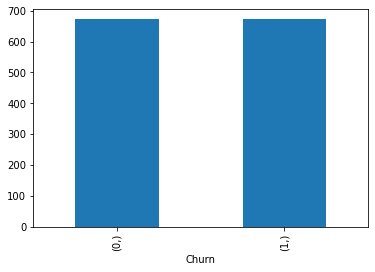

In [5]:
y_train.value_counts().plot(kind="bar")

## 3. Model the data
First, let's create a dataframe to load the model performance metrics into.


In [6]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

Conduct an initial random search across a wide range of possible parameters.

### 3.1 Decision Tree 
### Random Search Hyperparameter Tunning

## Metric Selection = Recall
Recall is a commonly used evaluation metric in churn prediction models, and it is often considered to be a more important metric than accuracy or precision for churn detection.

Recall, also known as sensitivity or true positive rate, measures the proportion of actual churners that are correctly identified as churners by the model. In other words, it measures the ability of the model to correctly identify all positive cases (i.e., customers who churned) out of the total number of positive cases. In the context of churn prediction, recall can be interpreted as the proportion of customers who are likely to churn that are correctly identified as such by the model. This is particularly important because identifying customers who are at risk of churning is critical for retaining them and minimizing customer churn.

In contrast, accuracy measures the proportion of all cases that are correctly identified by the model, regardless of whether they are positive or negative cases. Precision measures the proportion of predicted positive cases that are actually positive, and it is particularly useful in situations where the cost of false positives is high. However, in the context of churn prediction, the cost of false negatives (i.e., failing to identify customers who are likely to churn) is typically higher than the cost of false positives, making recall a more important metric for model evaluation.

Overall, while accuracy and precision are important metrics for evaluating the performance of churn prediction models, recall is often considered to be the most important metric for churn detection, as it directly measures the ability of the model to identify customers who are likely to churn.


In [7]:
score_measure = "recall"
kfolds = 15

criterion = ['gini', 'entropy']

max_depth = [int(x) for x in np.linspace(1, 4000, 10)]
min_samples_split = [int(x) for x in np.linspace(2, 5000, 10)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10000, 10)]
max_leaf_nodes = [int(x) for x in np.linspace(2, len(y_test), 50)]
min_impurity_decrease = [x for x in np.arange(0.0, 0.01, 0.0001).round(5)]


param_grid = {
    'min_samples_split': min_samples_split,  
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,
    'max_leaf_nodes': max_leaf_nodes, 
    'max_depth': max_depth, 
    'criterion': criterion,
}

dtree = DecisionTreeClassifier(random_state=random_seed)
best_random_search_model = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = best_random_search_model.fit(X_train, y_train)

Fitting 15 folds for each of 500 candidates, totalling 7500 fits


In [8]:
random_search_best_params = best_random_search_model.best_params_
print('Best parameters found: ', random_search_best_params)

Best parameters found:  {'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0012, 'max_leaf_nodes': 1585, 'max_depth': 2222, 'criterion': 'gini'}


### 3.2 Decision Tree Grid Search Hyperparameter tunning (Close to Random Search Value)

In [9]:
score_measure = "recall"
kfolds = 5

plus_minus = 4
increment = 2

param_grid = { 'min_samples_split': [x for x in range(random_search_best_params['min_samples_split']-plus_minus, random_search_best_params['min_samples_split']+plus_minus,2) if x >= 2],       
              'min_samples_leaf': [x for x in range(random_search_best_params['min_samples_leaf']-plus_minus , random_search_best_params['min_samples_leaf']+plus_minus,2) if x > 0],
              'min_impurity_decrease': [x for x in np.arange(random_search_best_params['min_impurity_decrease']-0.001, random_search_best_params['min_impurity_decrease']+0.001,.0001).round(5) if x >= 0.000],
              'max_leaf_nodes':[x for x in range(random_search_best_params['max_leaf_nodes']-plus_minus , random_search_best_params['max_leaf_nodes']+plus_minus, 2) if x > 1],  
              'max_depth': [x for x in range(random_search_best_params['max_depth']-plus_minus , random_search_best_params['max_depth']+plus_minus, 2) if x > 1],
              'criterion': [random_search_best_params['criterion']]
             }

dtree = DecisionTreeClassifier(random_state=random_seed)
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
The best recall score is 0.8587285793255942
... with parameters: {'criterion': 'gini', 'max_depth': 2218, 'max_leaf_nodes': 1581, 'min_impurity_decrease': 0.0004, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [10]:
c_matrix_dt = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix_dt[1][1]
TN = c_matrix_dt[0][0]
FP = c_matrix_dt[0][1]
FN = c_matrix_dt[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Decision Tree Grid_Search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 4.0 SVM Classification

### 4.1 SVM Random Search Hyperparameter tunning 

In [11]:
score_measure = "recall"
kfolds = 5

# defining parameter range
param_grid_svm = {
    'C': np.arange(1,25),
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf','poly'],
} 


best_random_search_model = RandomizedSearchCV(SVC(), param_distributions=param_grid_svm, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = best_random_search_model.fit(X_train, np.ravel(y_train))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [12]:
random_search_best_params = best_random_search_model.best_params_
print('Best parameters found: ', random_search_best_params)

Best parameters found:  {'kernel': 'rbf', 'gamma': 0.1, 'C': 9}


### 4.2 SVM Grid Search Hyperparameter tunning (Close to Randome Search Value)

In [13]:
score_measure = "recall"
kfolds = 5

# defining parameter range
param_grid_svm = {
    'C': np.arange(7,11,1),
    'gamma': np.arange(0.080,0.12,0.01),
    'kernel': ['rbf']
} 

grid_search_svm = GridSearchCV(SVC(), param_grid=param_grid_svm, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = grid_search_svm.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {grid_search_svm.best_score_}")
print(f"... with parameters: {grid_search_svm.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best recall score is 0.885428413488115
... with parameters: {'C': 7, 'gamma': 0.08, 'kernel': 'rbf'}


In [14]:
c_matrix_svm = confusion_matrix(y_test, grid_search_svm.predict(X_test))
TP = c_matrix_svm[1][1]
TN = c_matrix_svm[0][0]
FP = c_matrix_svm[0][1]
FN = c_matrix_svm[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"SVM Grid_Search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 5.0 Logistic Regression

### 5.1 Logistic Regression Random Search Hyperparameter Tunning

In [15]:
score_measure = "recall"
kfolds = 5

# defining parameter range
param_grid_log = {
    'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear']
} 

random_search_log = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid_log, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = random_search_log.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {random_search_log.best_score_}")
print(f"... with parameters: {random_search_log.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best recall score is 0.802089552238806
... with parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 4.281332398719396}


### 5.2 Logistic Regression Grid Search Hyperparameter Tunning (Very Close to Random search Values)

In [16]:
score_measure = "recall"
kfolds = 5

# defining parameter range
param_grid_log = {
    'penalty' : ['l1'],
    'C' : np.arange(2,7,1),
    'solver' : ['liblinear']
} 

grid_search_log = GridSearchCV(LogisticRegression(), param_grid=param_grid_log, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = grid_search_log.fit(X_train, np.ravel(y_train))

print(f"The best {score_measure} score is {grid_search_log.best_score_}")
print(f"... with parameters: {grid_search_log.best_params_}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best recall score is 0.802089552238806
... with parameters: {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}


In [17]:
c_matrix_log = confusion_matrix(y_test, grid_search_log.predict(X_test))
TP = c_matrix_log[1][1]
TN = c_matrix_log[0][0]
FP = c_matrix_log[0][1]
FN = c_matrix_log[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Logistic Grid_Search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 6.0 Neural Network

### 6.1 Neural Network Random Search Hyperparameter Tunning

In [18]:
%%time

score_measure = "recall"
kfolds = 5

param_grid = {
    'hidden_layer_sizes': [ (50,), (70,),(50,30), (40,20), (60,40, 20), (70,50,40)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0, .2, .5, .7, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.2, 0.5],
    'max_iter': [5000]
}

ann = MLPClassifier()
grid_search_neural = RandomizedSearchCV(estimator = ann, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search_neural.fit(X_train, y_train)

bestRecallTree = grid_search_neural.best_estimator_

print(grid_search_neural.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'solver': 'sgd', 'max_iter': 5000, 'learning_rate_init': 0.2, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (60, 40, 20), 'alpha': 0.2, 'activation': 'tanh'}
CPU times: total: 1.81 s
Wall time: 3min 31s


### 6.2 Neural Network Grid Search Hyperparameter Tunning (Very Close to Random search Values)

In [19]:
%%time

score_measure = "recall"
kfolds = 5

param_grid = {
    'hidden_layer_sizes': [ (60,40, 20)],
    'activation': ['relu'],
    'solver': ['sgd'],
    'alpha': np.arange(0.5,0.9,0.1),
    'learning_rate': ['adaptive'],
    'learning_rate_init': np.arange(0.18,0.22,0.01),
    'max_iter': [5000]
}

ann = MLPClassifier()
grid_search_nn = GridSearchCV(estimator = ann, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search_nn.fit(X_train, y_train)

bestRecallTree = grid_search_nn.best_estimator_

print(grid_search_nn.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'activation': 'relu', 'alpha': 0.7, 'hidden_layer_sizes': (60, 40, 20), 'learning_rate': 'adaptive', 'learning_rate_init': 0.18, 'max_iter': 5000, 'solver': 'sgd'}
CPU times: total: 1.14 s
Wall time: 1min 2s


In [20]:
c_matrix_nn = confusion_matrix(y_test, grid_search_nn.predict(X_test))
TP = c_matrix_nn[1][1]
TN = c_matrix_nn[0][0]
FP = c_matrix_nn[0][1]
FN = c_matrix_nn[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Neural Network Grid_Search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

# 7.0 Deep Neural Network

## Random Grid earch

In [21]:
%%time

def build_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    target_encoder_ = meta["target_encoder_"]
    
    model = tf.keras.models.Sequential()
    model.add(keras.layers.Input(shape=n_features_in_)),
    #for hidden_layer_size in hidden_layer_sizes:
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, 
            kernel_initializer= tf.keras.initializers.GlorotUniform(), 
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), 
            activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
%%time


from scikeras.wrappers import KerasClassifier

keras_clf = KerasClassifier(
    model=build_clf,
    hidden_layer_sizes=15,
    dropout=0.5,
    optimizer=keras.optimizers.Adam,
    optimizer__learning_rate=0.0001
)
keras_clf.get_params()


CPU times: total: 0 ns
Wall time: 12.5 ms


{'model': <function __main__.build_clf(meta, hidden_layer_sizes, dropout)>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': keras.optimizers.adam.Adam,
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 1,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1,
 'hidden_layer_sizes': 15,
 'dropout': 0.5,
 'optimizer__learning_rate': 0.0001,
 'class_weight': None}

In [23]:
%%time

params = {
    
    
    'model__hidden_layer_sizes': [(70,),(90, ), (100,), (100, 90)], 
    'model__dropout': [0, 0.1], 
    
    
    'batch_size':[20, 60, 100],
    'epochs':[10],
    'optimizer':['adam','sgd'],
    'loss':['binary_crossentropy'],
    
    
    'optimizer__learning_rate': [0.0001, 0.001, 0.01]

}
keras_clf.get_params()

CPU times: total: 0 ns
Wall time: 0 ns


{'model': <function __main__.build_clf(meta, hidden_layer_sizes, dropout)>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': keras.optimizers.adam.Adam,
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 1,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1,
 'hidden_layer_sizes': 15,
 'dropout': 0.5,
 'optimizer__learning_rate': 0.0001,
 'class_weight': None}

In [24]:
%%time

from sklearn.model_selection import RandomizedSearchCV
#from tensorflow.keras.callbacks import EarlyStopping

rnd_search_cv = RandomizedSearchCV(
    estimator=keras_clf, 
    param_distributions=params, 
    scoring='recall',  
    n_iter=50, 
    cv=3)

_ = rnd_search_cv.fit(X_train, y_train,  verbose=1)



Epoch 1/10
15/15 [==============================] - 1s 1ms/step - loss: 0.5731
Epoch 2/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4755
Epoch 3/10
15/15 [==============================] - 0s 922us/step - loss: 0.4500
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4378
Epoch 5/10
15/15 [==============================] - 0s 822us/step - loss: 0.4171
Epoch 6/10
15/15 [==============================] - 0s 963us/step - loss: 0.4090
Epoch 7/10
15/15 [==============================] - 0s 1ms/step - loss: 0.3887
Epoch 8/10
15/15 [==============================] - 0s 963us/step - loss: 0.3766
Epoch 9/10
15/15 [==============================] - 0s 1ms/step - loss: 0.3646
Epoch 10/10
8/8 [==============================] - 0s 874us/step
Epoch 1/10
15/15 [==============================] - 1s 1ms/step - loss: 0.5248
Epoch 2/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4399
Epoch 3/10
15/15 [==============================] - 0s 1ms

9/9 [==============================] - 0s 1ms/step - loss: 0.7045
Epoch 9/10
9/9 [==============================] - 0s 902us/step - loss: 0.6978
Epoch 10/10
5/5 [==============================] - 0s 1ms/step
Epoch 1/10
9/9 [==============================] - 0s 2ms/step - loss: 0.6997
Epoch 2/10
9/9 [==============================] - 0s 752us/step - loss: 0.6949
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6902
Epoch 4/10
9/9 [==============================] - 0s 996us/step - loss: 0.6855
Epoch 5/10
9/9 [==============================] - 0s 930us/step - loss: 0.6812
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6768
Epoch 7/10
9/9 [==============================] - 0s 800us/step - loss: 0.6723
Epoch 8/10
9/9 [==============================] - 0s 872us/step - loss: 0.6682
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6640
Epoch 10/10
5/5 [==============================] - 0s 991us/step
Epoch 1/10
9/9 [========

Epoch 5/10
45/45 [==============================] - 0s 878us/step - loss: 0.5662
Epoch 6/10
45/45 [==============================] - 0s 943us/step - loss: 0.5448
Epoch 7/10
45/45 [==============================] - 0s 863us/step - loss: 0.5174
Epoch 8/10
45/45 [==============================] - 0s 892us/step - loss: 0.5152
Epoch 9/10
45/45 [==============================] - 0s 962us/step - loss: 0.4922
Epoch 10/10
23/23 [==============================] - 0s 852us/step
Epoch 1/10
45/45 [==============================] - 1s 975us/step - loss: 0.6693
Epoch 2/10
45/45 [==============================] - 0s 1ms/step - loss: 0.6381
Epoch 3/10
45/45 [==============================] - 0s 972us/step - loss: 0.6115
Epoch 4/10
45/45 [==============================] - 0s 936us/step - loss: 0.5808
Epoch 5/10
45/45 [==============================] - 0s 888us/step - loss: 0.5600
Epoch 6/10
45/45 [==============================] - 0s 986us/step - loss: 0.5495
Epoch 7/10
45/45 [==========================

9/9 [==============================] - 0s 1ms/step - loss: 0.4767
Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.4373
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 0.4091
Epoch 5/10
9/9 [==============================] - 0s 1ms/step - loss: 0.3792
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 0.3569
Epoch 7/10
9/9 [==============================] - 0s 1ms/step - loss: 0.3243
Epoch 8/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2972
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 0.2678
Epoch 10/10
5/5 [==============================] - 0s 2ms/step
Epoch 1/10
15/15 [==============================] - 0s 1ms/step - loss: 0.7856
Epoch 2/10
15/15 [==============================] - 0s 1ms/step - loss: 0.7778
Epoch 3/10
15/15 [==============================] - 0s 1ms/step - loss: 0.7900
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 0.7758
Epoch 5/10
15/15

5/5 [==============================] - 0s 1ms/step
Epoch 1/10
45/45 [==============================] - 1s 1ms/step - loss: 0.6706
Epoch 2/10
45/45 [==============================] - 0s 964us/step - loss: 0.6531
Epoch 3/10
45/45 [==============================] - 0s 1ms/step - loss: 0.6298
Epoch 4/10
45/45 [==============================] - 0s 974us/step - loss: 0.6128
Epoch 5/10
45/45 [==============================] - 0s 1ms/step - loss: 0.5912
Epoch 6/10
45/45 [==============================] - 0s 1ms/step - loss: 0.5733
Epoch 7/10
45/45 [==============================] - 0s 1ms/step - loss: 0.5567
Epoch 8/10
45/45 [==============================] - 0s 1ms/step - loss: 0.5409
Epoch 9/10
45/45 [==============================] - 0s 1ms/step - loss: 0.5285
Epoch 10/10
23/23 [==============================] - 0s 709us/step
Epoch 1/10
45/45 [==============================] - 1s 1ms/step - loss: 0.6882
Epoch 2/10
45/45 [==============================] - 0s 1ms/step - loss: 0.6461
Epoch 3/1

Epoch 5/10
15/15 [==============================] - 0s 820us/step - loss: 0.6371
Epoch 6/10
15/15 [==============================] - 0s 962us/step - loss: 0.6294
Epoch 7/10
15/15 [==============================] - 0s 819us/step - loss: 0.6221
Epoch 8/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6151
Epoch 9/10
15/15 [==============================] - 0s 832us/step - loss: 0.6089
Epoch 10/10
8/8 [==============================] - 0s 1ms/step
Epoch 1/10
15/15 [==============================] - 1s 1ms/step - loss: 0.7525
Epoch 2/10
15/15 [==============================] - 0s 892us/step - loss: 0.7329
Epoch 3/10
15/15 [==============================] - 0s 862us/step - loss: 0.7156
Epoch 4/10
15/15 [==============================] - 0s 900us/step - loss: 0.6998
Epoch 5/10
15/15 [==============================] - 0s 786us/step - loss: 0.6855
Epoch 6/10
15/15 [==============================] - 0s 836us/step - loss: 0.6731
Epoch 7/10
15/15 [==============================] 

Epoch 1/10
45/45 [==============================] - 1s 1ms/step - loss: 0.6979
Epoch 2/10
45/45 [==============================] - 0s 984us/step - loss: 0.6827
Epoch 3/10
45/45 [==============================] - 0s 970us/step - loss: 0.6783
Epoch 4/10
45/45 [==============================] - 0s 1ms/step - loss: 0.6661
Epoch 5/10
45/45 [==============================] - 0s 880us/step - loss: 0.6569
Epoch 6/10
45/45 [==============================] - 0s 964us/step - loss: 0.6586
Epoch 7/10
45/45 [==============================] - 0s 997us/step - loss: 0.6496
Epoch 8/10
45/45 [==============================] - 0s 921us/step - loss: 0.6476
Epoch 9/10
45/45 [==============================] - 0s 897us/step - loss: 0.6395
Epoch 10/10
23/23 [==============================] - 0s 953us/step
Epoch 1/10
45/45 [==============================] - 1s 987us/step - loss: 0.7237
Epoch 2/10
45/45 [==============================] - 0s 976us/step - loss: 0.7176
Epoch 3/10
45/45 [============================

15/15 [==============================] - 0s 2ms/step - loss: 0.6784
Epoch 9/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6752
Epoch 10/10
8/8 [==============================] - 0s 857us/step
Epoch 1/10
15/15 [==============================] - 1s 2ms/step - loss: 0.7164
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 0.7077
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 0.7050
Epoch 4/10
15/15 [==============================] - 0s 2ms/step - loss: 0.7157
Epoch 5/10
15/15 [==============================] - 0s 1ms/step - loss: 0.7100
Epoch 6/10
15/15 [==============================] - 0s 1ms/step - loss: 0.7026
Epoch 7/10
15/15 [==============================] - 0s 1ms/step - loss: 0.7027
Epoch 8/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6999
Epoch 9/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6959
Epoch 10/10
8/8 [==============================] - 0s 1ms/step
Epoch 1/10
45/

15/15 [==============================] - 0s 1ms/step - loss: 0.4658
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4406
Epoch 5/10
15/15 [==============================] - 0s 997us/step - loss: 0.4344
Epoch 6/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4234
Epoch 7/10
15/15 [==============================] - 0s 926us/step - loss: 0.4115
Epoch 8/10
15/15 [==============================] - 0s 998us/step - loss: 0.3999
Epoch 9/10
15/15 [==============================] - 0s 967us/step - loss: 0.3838
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
Epoch 1/10
9/9 [==============================] - 0s 1ms/step - loss: 0.7386
Epoch 2/10
9/9 [==============================] - 0s 1ms/step - loss: 0.7293
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 0.7209
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 0.7130
Epoch 5/10
9/9 [==============================] - 0s 938us/step - loss: 0.7052


45/45 [==============================] - 0s 852us/step - loss: 0.3838
Epoch 10/10
23/23 [==============================] - 0s 842us/step
Epoch 1/10
45/45 [==============================] - 1s 848us/step - loss: 0.6582
Epoch 2/10
45/45 [==============================] - 0s 824us/step - loss: 0.6277
Epoch 3/10
45/45 [==============================] - 0s 844us/step - loss: 0.6023
Epoch 4/10
45/45 [==============================] - 0s 817us/step - loss: 0.5809
Epoch 5/10
45/45 [==============================] - 0s 893us/step - loss: 0.5619
Epoch 6/10
45/45 [==============================] - 0s 984us/step - loss: 0.5453
Epoch 7/10
45/45 [==============================] - 0s 872us/step - loss: 0.5305
Epoch 8/10
45/45 [==============================] - 0s 1ms/step - loss: 0.5178
Epoch 9/10
45/45 [==============================] - 0s 988us/step - loss: 0.5069
Epoch 10/10
23/23 [==============================] - 0s 825us/step
Epoch 1/10
45/45 [==============================] - 1s 958us/step - l

45/45 [==============================] - 0s 735us/step - loss: 0.5180
Epoch 4/10
45/45 [==============================] - 0s 726us/step - loss: 0.4907
Epoch 5/10
45/45 [==============================] - 0s 754us/step - loss: 0.4737
Epoch 6/10
45/45 [==============================] - 0s 716us/step - loss: 0.4646
Epoch 7/10
45/45 [==============================] - 0s 794us/step - loss: 0.4568
Epoch 8/10
45/45 [==============================] - 0s 805us/step - loss: 0.4513
Epoch 9/10
45/45 [==============================] - 0s 808us/step - loss: 0.4458
Epoch 10/10
23/23 [==============================] - 0s 717us/step
Epoch 1/10
45/45 [==============================] - 1s 880us/step - loss: 0.6651
Epoch 2/10
45/45 [==============================] - 0s 790us/step - loss: 0.5518
Epoch 3/10
45/45 [==============================] - 0s 756us/step - loss: 0.5004
Epoch 4/10
45/45 [==============================] - 0s 745us/step - loss: 0.4696
Epoch 5/10
45/45 [==============================] - 0

8/8 [==============================] - 0s 953us/step
Epoch 1/10
15/15 [==============================] - 0s 1ms/step - loss: 0.8195
Epoch 2/10
15/15 [==============================] - 0s 889us/step - loss: 0.8190
Epoch 3/10
15/15 [==============================] - 0s 782us/step - loss: 0.8185
Epoch 4/10
15/15 [==============================] - 0s 771us/step - loss: 0.8181
Epoch 5/10
15/15 [==============================] - 0s 749us/step - loss: 0.8176
Epoch 6/10
15/15 [==============================] - 0s 836us/step - loss: 0.8171
Epoch 7/10
15/15 [==============================] - 0s 935us/step - loss: 0.8167
Epoch 8/10
15/15 [==============================] - 0s 750us/step - loss: 0.8162
Epoch 9/10
15/15 [==============================] - 0s 964us/step - loss: 0.8157
Epoch 10/10
8/8 [==============================] - 0s 1ms/step
Epoch 1/10
15/15 [==============================] - 0s 957us/step - loss: 0.6637
Epoch 2/10
15/15 [==============================] - 0s 854us/step - loss: 0.

15/15 [==============================] - 0s 1ms/step - loss: 0.6837
Epoch 9/10
15/15 [==============================] - 0s 963us/step - loss: 0.6819
Epoch 10/10
8/8 [==============================] - 0s 784us/step
Epoch 1/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6678
Epoch 2/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6662
Epoch 3/10
15/15 [==============================] - 0s 929us/step - loss: 0.6647
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6633
Epoch 5/10
15/15 [==============================] - 0s 891us/step - loss: 0.6618
Epoch 6/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6604
Epoch 7/10
15/15 [==============================] - 0s 857us/step - loss: 0.6591
Epoch 8/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6577
Epoch 9/10
15/15 [==============================] - 0s 889us/step - loss: 0.6563
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
Epoc

9/9 [==============================] - 0s 1ms/step - loss: 0.6820
Epoch 4/10
9/9 [==============================] - 0s 931us/step - loss: 0.6728
Epoch 5/10
9/9 [==============================] - 0s 877us/step - loss: 0.6639
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6557
Epoch 7/10
9/9 [==============================] - 0s 998us/step - loss: 0.6479
Epoch 8/10
9/9 [==============================] - 0s 937us/step - loss: 0.6406
Epoch 9/10
9/9 [==============================] - 0s 941us/step - loss: 0.6338
Epoch 10/10
5/5 [==============================] - 0s 829us/step
Epoch 1/10
45/45 [==============================] - 1s 928us/step - loss: 0.5294
Epoch 2/10
45/45 [==============================] - 0s 868us/step - loss: 0.4708
Epoch 3/10
45/45 [==============================] - 0s 841us/step - loss: 0.4577
Epoch 4/10
45/45 [==============================] - 0s 872us/step - loss: 0.4388
Epoch 5/10
45/45 [==============================] - 0s 861us/step - loss:

5/5 [==============================] - 0s 2ms/step
Epoch 1/10
9/9 [==============================] - 0s 1ms/step - loss: 0.7191
Epoch 2/10
9/9 [==============================] - 0s 995us/step - loss: 0.7030
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6886
Epoch 4/10
9/9 [==============================] - 0s 870us/step - loss: 0.6756
Epoch 5/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6639
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6531
Epoch 7/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6432
Epoch 8/10
9/9 [==============================] - 0s 872us/step - loss: 0.6340
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6255
Epoch 10/10
5/5 [==============================] - 0s 1ms/step
Epoch 1/10
9/9 [==============================] - 0s 1ms/step - loss: 0.7612
Epoch 2/10
9/9 [==============================] - 0s 872us/step - loss: 0.7219
Epoch 3/10
9/9 [===============

9/9 [==============================] - 0s 1ms/step - loss: 0.6304
Epoch 7/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6203
Epoch 8/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6116
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6093
Epoch 10/10
5/5 [==============================] - 0s 2ms/step
Epoch 1/10
9/9 [==============================] - 0s 2ms/step - loss: 0.7764
Epoch 2/10
9/9 [==============================] - 0s 1ms/step - loss: 0.7329
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 0.7103
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6857
Epoch 5/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6709
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6563
Epoch 7/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6446
Epoch 8/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6347
Epoch 9/10
9/9 [========

In [25]:
rnd_search_cv.best_params_

{'optimizer__learning_rate': 0.01,
 'optimizer': 'adam',
 'model__hidden_layer_sizes': (100,),
 'model__dropout': 0.1,
 'loss': 'binary_crossentropy',
 'epochs': 10,
 'batch_size': 60}

In [26]:
best_model = rnd_search_cv.best_estimator_

In [27]:
best_model.history_

defaultdict(list,
            {'loss': [0.5453055500984192,
              0.4715122580528259,
              0.4366137981414795,
              0.41592860221862793,
              0.403006911277771,
              0.3976524770259857,
              0.38485950231552124,
              0.36969682574272156,
              0.3636505901813507,
              0.35723787546157837]})

29/29 [==============================] - 0s 739us/step


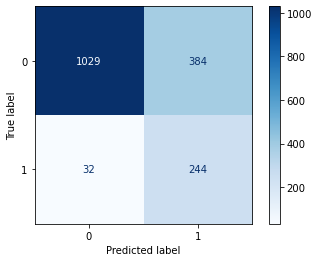

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [29]:
c_matrix_dnn = confusion_matrix(y_test, best_model.predict(X_test))
TP = c_matrix_dnn[1][1]
TN = c_matrix_dnn[0][0]
FP = c_matrix_dnn[0][1]
FN = c_matrix_dnn[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Deep Neural Network", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

29/29 [==============================] - 0s 786us/step


## 8.0 Performance Evaluation and Comparison of Models

In [30]:
performance

,model,Accuracy,Precision,Recall,F1
0,Decision Tree Grid_Search,0.827709,0.485207,0.891304,0.628352
0,SVM Grid_Search,0.839550,0.505071,0.902174,0.647594
0,Logistic Grid_Search,0.769686,0.397086,0.789855,0.528485
0,Neural Network Grid_Search,0.858496,0.540839,0.887681,0.672154
0,Deep Neural Network,0.753700,0.388535,0.884058,0.539823


## 9.0 Confusion Matrix for cost evaluation of best model (SVM)

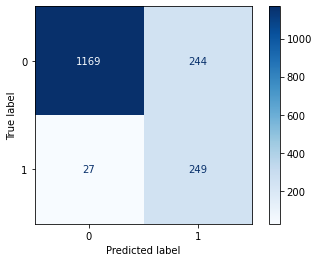

In [32]:
 ## Confusion matric of SVM model
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix_svm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 9.1 Discussion of Adding MLP Classifier & Deep Neural Network (Keras) classification to the model

Even adding MLP & Deep Neural network (Keras) classification to the model above, it produces Recall of 88.40% (DNN) & 88.76% (MLP) which is underperformed compared to SVM. Hence to solve our problem statement we will continue with SVM as our best model with recall of 90.21%.  

## 9.2 Discussion of Confusion Matrix for cost evaluation of best model (SVM)

The confusion matrix for the best model (reveals that there were 249 true positives (TP), 1169 true negatives (TN), 244 false positives (FP), and 27 false negatives (FN). The imbalanced target variable is a possible reason for such values.

Let's now examine how this churn detection model can benefit the e-commerce business in financial terms. Let's assume that the business generates an average revenue of USD 100 per month per customer, with an average customer lifetime value of USD 1,000. If the churn detection model can accurately identify an additional 10 customers per month who are at risk of churning, and the business can retain these customers, it would result in an extra monthly revenue of USD 1,000 (USD 100 per customer * 10 customers) and an additional customer lifetime value of USD 10,000 (USD 1,000 per customer * 10 customers) over the lifetime of these customers.

However, in our case from the confusion matrix there were 27 false negatives, meaning that the model predicted that these customers would not churn, whereas they actually churned. Based on the example values, the business would lose USD 2,700 per month (USD 100 per customer * 30 customers) and an additional customer lifetime value of USD 27,000 (USD 1,000 per customer * 30 customers) over the lifetime of these customers.

# Conclusion

### Churn detection is a crucial aspect for e-commerce businesses as it can have a significant impact on various factors such as revenue, customer lifetime value, customer satisfaction, and competition. It helps identify customers who are likely to leave, enabling businesses to take proactive measures to retain them and prevent revenue loss. Out of the three evaluated models, the SVM model has the highest recall value of 90.21%, which is the most important metric for churn detection. Besides recall, accuracy is also crucial as it reduces the number of false negatives and focuses on true positive customers. With a recall score of 0.902, the model can correctly identify 90.2% of customers who are likely to churn, indicating its ability to identify a significant proportion of at-risk customers.

